In [97]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
import Plot3D as plot3d


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Neural ODE's

In [98]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out

In [99]:
class Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, hidden_layers, depth, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, hidden_layers, depth, spatial_dim, activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = spatial_dim



    def forward(self, t, x):
        out = self.network(x)
        return out

In [276]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, hidden_layers, depth, time_range, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, hidden_layers, depth, spatial_dim*(num_breakpoints+1), activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = spatial_dim
        self.num_breakpoint     = num_breakpoints
        self.time_range         = time_range
        self.num_A              = (num_breakpoints+1)
        self.breakpoints        = torch.linspace(time_range[0], time_range[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
        self.k = 1  #steepness parameter for sigmoid function
    
    
    def sigmoid(self, x):
       out = torch.sigmoid(self.k*x)
       return out
    


    def forward(self, t, x):
     
        out = self.network(x).reshape(self.num_A, self.variables)

        #First interval 
        i1 = self.sigmoid(self.break_params[0] - t).unsqueeze(0)
        output = i1

        #Internal Intervals
        for i in range(0, self.break_params.shape[0]-1):
            a = self.sigmoid(t - self.break_params[i]).unsqueeze(0)
            b = self.sigmoid(self.break_params[i+1] - t).unsqueeze(0)
            c = a*b
            output = torch.concatenate([output, c])
            
        #Final interval 
        i_final = self.sigmoid(t - self.break_params[-1]).unsqueeze(0)
        output = torch.cat([output, i_final])
        indicator = output.unsqueeze(0).T


        out2 = out*indicator
        final_out = torch.sum(out2, dim=0)
        return final_out

# Lorenz System

In [277]:
class Lorenz_nonauto:
    def __init__(self, rho, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t) - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

In [278]:
#### Batching 
def batch(data, t, batch_length, batch_size): # data shape (traj, dim, time) #All traj same length 

    num_traj = data.shape[0]
    data_length = data.shape[2]

    traj_indices = np.random.randint(0, num_traj, batch_size)
    ic_indices = np.random.randint(0, data_length - batch_length, batch_size)

    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[traj_indices[i], :, ic_indices[i]:ic_indices[i]+batch_length].float())
        batch_time_list.append(t[ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list

In [279]:
t_Start = 0; t_Final =20; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt); y0 = [1, 1, 1]

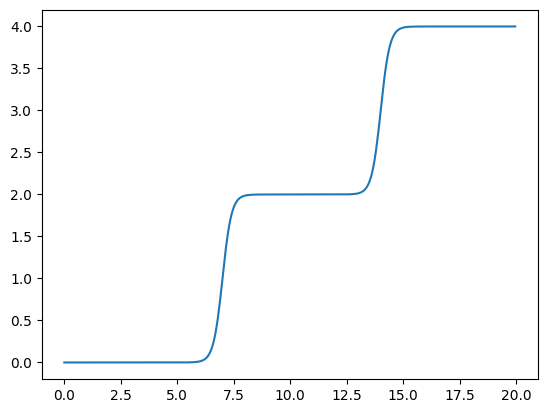

In [280]:
## Sigmoid r 
k = 5
s_k = lambda t: torch.sigmoid(torch.tensor(k*t)).detach().numpy()

transition_pts = [7.0, 14.0]

parameter_f = lambda t: 2*s_k(t-transition_pts[0]) + 2*s_k(t-transition_pts[1]) 

t_Start = 0.0; t_Final = 20; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt)
x= np.vectorize(parameter_f)(np.arange(0.0, 20.0, dt))
t = np.arange(0.0, 20.0, dt)
plt.plot(t, x)

In [281]:
lorenz = Lorenz_nonauto(rho = parameter_f)

In [282]:
output = integ.solve_ivp(lorenz.f, t_span=(t_Start, t_Final), y0=[1, 1, 1],
                            method = 'RK45', t_eval = t_Eval)
data1 = output.y

output = integ.solve_ivp(lorenz.f, t_span=(t_Start, t_Final), y0=[-1, -1, 1],
                            method = 'RK45', t_eval = t_Eval)
data2 = output.y
training_data = np.array([data1, data2])

# Training Model 1

In [333]:
model = Piecewise_Auto_NODE(spatial_dim=3, hidden_layers=3, depth = 15, time_range = [0, 20], num_breakpoints=2)

In [334]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Putting data into tensor 
t_eval_tensor =  torch.tensor(np.arange(t_Start, t_Final, dt))
data_tensor = torch.tensor(training_data)

In [335]:
#Single training loop
optimizer.zero_grad()
pred_x = odeint(model, data_tensor[0, :, 0].float(), 
                t_eval_tensor.float(), method='rk4', options={'step_size': dt})

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, data_tensor[0, :, :].T.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(1.0294, grad_fn=<MeanBackward0>)

Breakpoint:  Parameter containing:
tensor([ 6.6677, 13.3323], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.0029,  0.0021])


In [ ]:
batch_length = 100
batch_size = 5
num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    
    batch_list, batch_time_list = batch(data_tensor, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[:, 0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.T)
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            temp_list = []
            for i in range(0, data_tensor.shape[0]):
                pred_x = odeint(model, data_tensor[i, :, 0].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
                train_loss = loss_fn(pred_x, data_tensor[i,:,:].T)
                temp_list.append(train_loss.item())

            loss_list.append(np.array(temp_list).mean())
               
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/5000 [00:03<5:09:53,  3.72s/it]

Epoch 0, Loss: 0.45492049956081443


  2%|▏         | 101/5000 [03:35<3:20:10,  2.45s/it]

Epoch 100, Loss: 0.35217795414833797


  4%|▍         | 201/5000 [06:53<3:04:13,  2.30s/it]

Epoch 200, Loss: 0.5948247635020771


  6%|▌         | 301/5000 [10:32<3:27:06,  2.64s/it]

Epoch 300, Loss: 1.226707130984524


  8%|▊         | 401/5000 [14:10<3:12:28,  2.51s/it]

Epoch 400, Loss: 1.295995295415317


 10%|█         | 501/5000 [17:47<3:16:13,  2.62s/it]

Epoch 500, Loss: 0.3443531437737034


 12%|█▏        | 601/5000 [21:25<3:05:41,  2.53s/it]

Epoch 600, Loss: 0.30502348223217035


 14%|█▍        | 701/5000 [25:03<3:00:30,  2.52s/it]

Epoch 700, Loss: 1.4002574956045213


 16%|█▌        | 801/5000 [28:40<2:58:06,  2.54s/it]

Epoch 800, Loss: 1.042357139264378


 18%|█▊        | 901/5000 [32:16<2:56:06,  2.58s/it]

Epoch 900, Loss: 1.1215988402352313


 20%|██        | 1001/5000 [35:53<2:47:46,  2.52s/it]

Epoch 1000, Loss: 1.084486671651133


 22%|██▏       | 1101/5000 [39:29<2:48:24,  2.59s/it]

Epoch 1100, Loss: 1.042439617529074


 24%|██▍       | 1201/5000 [43:07<2:42:56,  2.57s/it]

Epoch 1200, Loss: 1.0696896033811982


 26%|██▌       | 1301/5000 [46:46<2:39:28,  2.59s/it]

Epoch 1300, Loss: 1.0497405223362863


 28%|██▊       | 1401/5000 [50:25<2:30:58,  2.52s/it]

Epoch 1400, Loss: 1.0233601187118022


 30%|███       | 1501/5000 [54:03<2:32:41,  2.62s/it]

Epoch 1500, Loss: 1.0378154929717516


 32%|███▏      | 1601/5000 [57:44<2:25:58,  2.58s/it]

Epoch 1600, Loss: 0.13446984100686965


 34%|███▍      | 1701/5000 [1:01:26<2:22:22,  2.59s/it]

Epoch 1700, Loss: 0.1641361659931577


 36%|███▌      | 1801/5000 [1:05:07<2:14:51,  2.53s/it]

Epoch 1800, Loss: 0.14509730585779693


 38%|███▊      | 1901/5000 [1:08:47<2:20:28,  2.72s/it]

Epoch 1900, Loss: 0.12358050654226906


 40%|████      | 2001/5000 [1:12:26<2:09:57,  2.60s/it]

Epoch 2000, Loss: 1.0593079482325658


 42%|████▏     | 2101/5000 [1:16:07<2:07:36,  2.64s/it]

Epoch 2100, Loss: 0.10882595172386895


 44%|████▍     | 2201/5000 [1:19:47<1:59:59,  2.57s/it]

Epoch 2200, Loss: 0.8827993980282463


 46%|████▌     | 2301/5000 [1:23:27<1:50:14,  2.45s/it]

Epoch 2300, Loss: 0.18330737070886366


 48%|████▊     | 2401/5000 [1:27:08<1:51:57,  2.58s/it]

Epoch 2400, Loss: 0.9339057332874063


 50%|█████     | 2501/5000 [1:30:50<1:45:39,  2.54s/it]

Epoch 2500, Loss: 0.09740330350928188


 52%|█████▏    | 2601/5000 [1:34:32<1:46:05,  2.65s/it]

Epoch 2600, Loss: 1.0495970066254117


 54%|█████▍    | 2701/5000 [1:38:10<1:38:37,  2.57s/it]

Epoch 2700, Loss: 0.1273269643104606


 56%|█████▌    | 2801/5000 [1:41:43<1:31:27,  2.50s/it]

Epoch 2800, Loss: 1.101479362833423


 58%|█████▊    | 2901/5000 [1:45:18<1:31:35,  2.62s/it]

Epoch 2900, Loss: 1.0416426947903907


 60%|██████    | 3001/5000 [1:48:55<1:24:31,  2.54s/it]

Epoch 3000, Loss: 0.27766448403696486


 62%|██████▏   | 3101/5000 [1:52:31<1:21:48,  2.58s/it]

Epoch 3100, Loss: 0.995028249991895


 64%|██████▍   | 3201/5000 [1:56:08<1:17:32,  2.59s/it]

Epoch 3200, Loss: 0.11097751164550256


 66%|██████▌   | 3301/5000 [1:59:50<1:13:29,  2.60s/it]

Epoch 3300, Loss: 0.09290880583443044


 68%|██████▊   | 3401/5000 [2:03:33<1:08:51,  2.58s/it]

Epoch 3400, Loss: 0.10938099412887155


 70%|███████   | 3501/5000 [2:07:13<1:07:09,  2.69s/it]

Epoch 3500, Loss: 0.9965084022616449


 72%|███████▏  | 3601/5000 [2:10:56<1:00:33,  2.60s/it]

Epoch 3600, Loss: 0.1326676765593293


 74%|███████▍  | 3701/5000 [2:14:37<56:15,  2.60s/it]  

Epoch 3700, Loss: 0.11060932814601339


 76%|███████▌  | 3801/5000 [2:18:15<47:56,  2.40s/it]

Epoch 3800, Loss: 0.12540689603278857


 78%|███████▊  | 3901/5000 [2:21:58<45:20,  2.48s/it]

Epoch 3900, Loss: 0.9842418750362582


 80%|████████  | 4001/5000 [2:25:28<40:03,  2.41s/it]

Epoch 4000, Loss: 1.008570198683129


 82%|████████▏ | 4101/5000 [2:29:05<38:10,  2.55s/it]

Epoch 4100, Loss: 0.09253606148172888


 84%|████████▍ | 4201/5000 [2:32:45<34:16,  2.57s/it]

Epoch 4200, Loss: 1.0548881576852778


 86%|████████▌ | 4301/5000 [2:36:24<30:49,  2.65s/it]

Epoch 4300, Loss: 1.0381654682532224


 88%|████████▊ | 4401/5000 [2:40:04<25:32,  2.56s/it]

Epoch 4400, Loss: 0.10463420457488522


 90%|█████████ | 4501/5000 [2:43:45<22:15,  2.68s/it]

Epoch 4500, Loss: 0.09947450282053348


 92%|█████████▏| 4601/5000 [2:47:27<17:14,  2.59s/it]

Epoch 4600, Loss: 0.9949186303881599


 94%|█████████▍| 4701/5000 [2:51:09<12:54,  2.59s/it]

Epoch 4700, Loss: 1.019356640100481


 96%|█████████▌| 4801/5000 [2:54:51<08:34,  2.59s/it]

Epoch 4800, Loss: 0.08695510091032767


 98%|█████████▊| 4899/5000 [2:58:27<03:36,  2.14s/it]

In [1]:
### Analysis  
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, 1000, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, 1000)


ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, 1000, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
ax2.grid()
#plt.xscale('log')
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

NameError: name 'plt' is not defined

# Training Model 2

In [ ]:
model2 = Piecewise_Auto_NODE(spatial_dim=3, hidden_layers=3, depth = 15, time_range = [0, 20], num_breakpoints=10)

In [ ]:
#Saving loss and setting optimiser 
loss_list2 = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Putting data into tensor 
t_eval_tensor =  torch.tensor(np.arange(t_Start, t_Final, dt))
data_tensor = torch.tensor(training_data)

In [ ]:
#Single training loop
optimizer.zero_grad()
pred_x = odeint(model, data_tensor[0, :, 0].float(), 
                t_eval_tensor.float(), method='rk4', options={'step_size': dt})

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, data_tensor[0, :, :].T.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(1.0294, grad_fn=<MeanBackward0>)

Breakpoint:  Parameter containing:
tensor([ 6.6677, 13.3323], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.0029,  0.0021])


In [ ]:
batch_length = 100
batch_size = 5
num_epochs = 5000
for epoch in tqdm(range(num_epochs)):
    
    batch_list, batch_time_list = batch(data_tensor, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[:, 0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.T)
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            temp_list = []
            for i in range(0, data_tensor.shape[0]):
                pred_x = odeint(model, data_tensor[i, :, 0].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
                train_loss = loss_fn(pred_x, data_tensor[i,:,:].T)
                temp_list.append(train_loss.item())

            loss_list.append(np.array(temp_list).mean())
               
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/1000 [00:03<55:39,  3.34s/it]

Epoch 0, Loss: 1.2266928651188118


  4%|▍         | 40/1000 [01:26<34:35,  2.16s/it]


In [ ]:
data_tensor.shape

torch.Size([2, 3, 400])